This code replicates the tables 1,2, A1, and A2 from the Replication Replication of Dickens (2022) “Understanding Ethnolinguistic Differences: The Roles of Geography and Trade". In addition it creates Figure 2 and Figure 4.

In our analysis we re-create buffers from the Ethnologue v16 and v17 (You can find the notebook XXXXX that processes the Ethnologe v16 and v17). In addition, we use an alternative way of measuring CSI at each buffer. 

Each column of table 2 and table A2 represents a pair of data and independent variables of interest.

- `og variable` is the variable used by Dicken in his analysis (CSI sd and CSI average)
- `our variable` is our defined CSI calculated for buffers similar to Dickens reconstructed from scratch.
- `alt variable` is our defined CSI calculated for alternative buffers.

The code below defines the user functions `mysample` for the regressions and `myheatmaps` to produce the heatmaps.

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys, os, time
pd.set_option('display.width', 140)

# Geo
from shapely.geometry import Polygon, Point
import geopandas as gp
import geopandas.tools as gpt
gpd = gp

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

from IPython.display import display, HTML, Image

# Set paths

pathgraphs = '/work/tables and figures/'

The following code blocks contain the user-defined functions to create the HTML tables (html_table1 and html_table2), format the correlation matrices myheatmap, and select the samples to run regressions with mysample.

In [ ]:
# User defined regressions

# Sample
def mysample(myvars, df, FE=True, dummy_cols=['cell_ISO3'],
             cluster_cols = ['cell_ISO3'], zscores=True):
    '''
    Create sample dataframe based on variables
    First variable is dependent variable
    It adds dummies for FE
    Adds cluster variables
    '''
    if len(myvars)<2:
        print('A regression needs at least one dependent and one independent variable!')
        pass
    else:
        k = 0
        for v in myvars:
            if k==0:
                mydf = (df[v].isnull()==False).astype(int)
                k += 1
            else:
                mydf *= (df[v].isnull()==False).astype(int)
        mydf = df.loc[mydf==1].reset_index(drop=True).copy()
        if zscores:
            mydf[myvars] = mydf[myvars].apply(zscore)
        myeq = myvars[0] + ' ~ ' + " + ".join(myvars[1:])
        if FE:
            dummies = pd.get_dummies(mydf[dummy_cols], prefix='_I', prefix_sep='_')
            dummies = dummies.T.groupby(level=0).sum().T
            dummy_columns = " + ".join(dummies.columns)
            myeq += ' + ' + dummy_columns
            mydf = mydf.merge(dummies, left_index=True, right_index=True).copy()
        clustercols = []
        for v in cluster_cols:
            mydf['cluster_'+v] = mydf[v].astype('category').cat.codes
            clustercols.append('cluster_'+v)
        return [mydf, myeq, clustercols]

def myheatmap(df,varx,vary,gname ,show = False):
    """
    Create a heatmap to illustrate how correlated two sets of variables (var1 and var2)

    INPUTS: 
    df = pandas Dataframe
    varx = list of variables names contained in the dataframe (plotted in the x_axis)
    vary = list of variables names contained in the dataframe (plotted in the y_axis)
    gname = string with the name of the output plot
    show = boolean to show the plot in the notebook (True) or not (False)
    """
    dfheat = df[varx + vary].corr()
    dfheat = dfheat.loc[varx,vary]
    fig, ax = plt.subplots(figsize=(15,10), facecolor='w', edgecolor='w')
    sns.heatmap(dfheat, cmap=sns.cm.rocket_r, xticklabels=True, yticklabels=True, cbar=False, vmin=0, vmax=1,
                annot=True, fmt=".2f", linewidth=.5, annot_kws={"size":28}, ax =ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':24})
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':20})
    plt.savefig( pathgraphs + gname + '.pdf', dpi=300, bbox_inches='tight')
    if show == False:
        plt.close()

In [ ]:
def html_table_1(name):
    """
    
    INPUTS: 
    name = string with the name of the output table in .tex
    """
    
    start = r"""<table>
<thead>
<tr class="header">
<th style="text-align: left;"></th>
<th colspan="6" style="text-align: center;">Dependent variable:
Lexicostatistical linguistic distance <span
class="math inline">∈(0,1)</span></th>
<th style="text-align: center;"></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left;"><span></span></td>
<td style="text-align: center;">(1)</td>
<td style="text-align: center;">(2)</td>
<td style="text-align: center;">(3)</td>
<td style="text-align: center;">(4)</td>
<td style="text-align: center;">(5)</td>
<td style="text-align: center;">(6)</td>
</tr>
"""
    post_land_prod_var_change = r"""<tr class="even">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in land productivity variation
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd'],est5_b['csi_change_sd'],est6_b['csi_change_sd'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd'],est5_se['csi_change_sd'],est6_se['csi_change_sd'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd'],est5_p['csi_change_sd'],est6_p['csi_change_sd'])
    pre_land_prod_var = r"""<tr class="odd">
<td style="text-align: left;">Land productivity variation
(pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd'],est5_b['csi_sd'],est6_b['csi_sd'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd'],est5_se['csi_sd'],est6_se['csi_sd'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd'],est5_p['csi_sd'],est6_p['csi_sd'])    
    post_land_prod_change = r"""<tr class="even">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in land productivity
(post-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change'],est5_b['csi_change'],est6_b['csi_change'],
               est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change'],est5_se['csi_change'],est6_se['csi_change'],
               est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change'],est5_p['csi_change'],est6_p['csi_change'])    
    pre_land_prod = r"""<tr class="odd">
<td style="text-align: left;">Land productivity (pre-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est2_b['csi'],est3_b['csi'],est4_b['csi'],est5_b['csi'],est6_b['csi'],
               est2_se['csi'],est3_se['csi'],est4_se['csi'],est5_se['csi'],est6_se['csi'],
               est2_p['csi'],est3_p['csi'],est4_p['csi'],est5_p['csi'],est6_p['csi'])
    FE_rows = r"""<tr class="even">
<td style="text-align: left;">Geography controls</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Spatial controls</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="even">
<td style="text-align: left;">Language family FEs</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Country FEs</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
</tr>"""
    
    R2_obs = r"""<tr class="even">
<td style="text-align: left;">Adjusted <span
class="math inline"><em>R</em><sup>2</sup></span></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Observations</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
</tr>""".format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,
               N1,N2,N3,N4,N5,N6)
    end = r"""</tbody>
</table>
<p> Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.</p>"""
    with open(pathgraphs + name + '.html', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod) 
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

In [ ]:
def html_table_2(name):
    """

    INPUTS: 
    name = string with the name of the output table in .tex
    """
    
    start = r"""<table>
<thead>
<tr class="header">
<th style="text-align: left;"></th>
<th colspan="9" style="text-align: center;">Dependent variable:
Lexicostatistical linguistic distance <span
class="math inline"> ∈ (0,1)</span></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left;"></td>
<td colspan="5" style="text-align: center;">Replication</td>
<td colspan="4" style="text-align: center;">Robustness</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td colspan="3" style="text-align: center;">Original Data</td>
<td colspan="2" style="text-align: center;">Reconstructed Data</td>
<td colspan="4" style="text-align: center;">Alternative Measure</td>
</tr>
<tr class="odd">
<td
style="text-align: left;"></td>
<td style="text-align: center;">Original Sample</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
</tr>
<tr class="even">
<td
style="text-align: left;"></td>
<td style="text-align: center;">(1)</td>
<td style="text-align: center;">(2)</td>
<td style="text-align: center;">(3)</td>
<td style="text-align: center;">(4)</td>
<td style="text-align: center;">(5)</td>
<td style="text-align: center;">(6)</td>
<td style="text-align: center;">(7)</td>
<td style="text-align: center;">(8)</td>
<td style="text-align: center;">(9)</td>
</tr>"""
    post_land_prod_var_change = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in land productivity variation
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd_oj'],est5_b['csi_change_sd_oj'],est8_b['csi_change_sd'],est9_b['csi_change_sd'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd_oj'],est5_se['csi_change_sd_oj'],est8_se['csi_change_sd'],est9_se['csi_change_sd'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd_oj'],est5_p['csi_change_sd_oj'],est8_p['csi_change_sd'],est9_p['csi_change_sd'])
    
    pre_land_prod_var = r"""<tr class="even">
<td style="text-align: left;">Land productivity variation
(pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd_oj'],est5_b['csi_sd_oj'],est8_b['csi_sd'],est9_b['csi_sd'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd_oj'],est5_se['csi_sd_oj'],est8_se['csi_sd'],est9_se['csi_sd'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd_oj'],est5_p['csi_sd_oj'],est8_p['csi_sd'],est9_p['csi_sd'])
    
    post_land_prod_change = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in land productivity
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_change'],est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change_oj'],est5_b['csi_change_oj'],est6_b['csi_change'],est7_b['csi_change'],est8_b['csi_change'],est9_b['csi_change'],
               est1_se['csi_change'],est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change_oj'],est5_se['csi_change_oj'],est6_se['csi_change'],est7_se['csi_change'],est8_se['csi_change'],est9_se['csi_change'],
               est1_p['csi_change'],est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change_oj'],est5_p['csi_change_oj'],est6_p['csi_change'],est7_p['csi_change'],est8_p['csi_change'],est9_p['csi_change'])
    
    pre_land_prod = r"""<tr class="even">
<td style="text-align: left;">Land productivity (pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi'],est2_b['csi'],est3_b['csi'],est4_b['csi_oj'],est5_b['csi_oj'],est6_b['csi'],est7_b['csi'],est8_b['csi'],est9_b['csi'],
           est1_se['csi'],est2_se['csi'],est3_se['csi'],est4_se['csi_oj'],est5_se['csi_oj'],est6_se['csi'],est7_se['csi'],est8_se['csi'],est9_se['csi'],
           est1_p['csi'],est2_p['csi'],est3_p['csi'],est4_p['csi_oj'],est5_p['csi_oj'],est6_p['csi'],est7_p['csi'],est8_p['csi'],est9_p['csi'])
    
    cross_border = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in cross border <span
class="math inline"><em>Δ</em></span> in land productivity
(post-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est6_b['csi_change_alt'],est7_b['csi_change_alt'],est8_b['csi_change_alt'],est9_b['csi_change_alt'],
           est6_se['csi_change_alt'],est7_se['csi_change_alt'],est8_se['csi_change_alt'],est9_se['csi_change_alt'],
           est6_p['csi_change_alt'],est7_p['csi_change_alt'],est8_p['csi_change_alt'],est9_p['csi_change_alt'])
    
    cross_border2 = r"""<tr class="even">
<td style="text-align: left;">Cross border <span
class="math inline"><em>Δ</em></span> in land productivity
(pre-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est6_b['csi_alt'],est7_b['csi_alt'],est8_b['csi_alt'],est9_b['csi_alt'],
           est6_se['csi_alt'],est7_se['csi_alt'],est8_se['csi_alt'],est9_se['csi_alt'],
           est6_p['csi_alt'],est7_p['csi_alt'],est8_p['csi_alt'],est9_p['csi_alt'])
    
    FE_rows = r"""<tr class="odd">
<td style="text-align: left;">Geography controls</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="even">
<td style="text-align: left;">Spatial controls</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Language family FEs</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>"""
    
    R2_obs = r"""<tr class="even">
<td style="text-align: left;">Adjusted <span
class="math inline"><em>R</em><sup>2</sup></span></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Observations</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
</tr>""".format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,ad_R7,ad_R8,ad_R9,
           N1,N2,N3,N4,N5,N6,N7,N8,N9)
    
    end = r"""</tbody>
</table>
<p> Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.</p>
"""
    with open(pathgraphs + name + '.html', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod)
        file.write(cross_border)
        file.write(cross_border2)
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

# Loading the Datasets and Shapefiles

The Notebook XXXXX prepares the datasets using the Ethnologe v16 and v17.

We will detail what we encountered and how we solved those problems

In [ ]:
# Load all datasets
dfor16 = pd.read_stata('/work/data/Dickens_rep_v16.dta')
dfor17 = pd.read_stata('/work/data/Dickens_rep_v17.dta')

# For specification (6) in Table 1 we drop the singletons when they are in the same country.
dfor_same_country = dfor16[dfor16.samecountry == 1]
category_counts = dfor_same_country.groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country.groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country.groupby('ccode1').identifier.count()
singletop_ccode = category_counts[category_counts == 1].index.tolist()

dfor_same_country = dfor_same_country[(~dfor_same_country.family1.isin(singletop_fam1)) & (~dfor_same_country.family2.isin(singletop_fam2)) & (~dfor_same_country.ccode1.isin(singletop_ccode))]

# Load Shapefiles
shapefile_path = '/work/data/shapefiles/'
africa_or = gp.read_file(shapefile_path + 'Africa_Country_Borders.shp')
border_or = gp.read_file(shapefile_path + 'Border.shp')
manyika_or = gp.read_file(shapefile_path + 'Manyika.shp')
shona_or = gp.read_file(shapefile_path + 'Shona.shp')
buffer_or = gp.read_file(shapefile_path + 'Shona_Manyika_Buffer.shp')

# Reproject everything to same projection
buffer_or['NAM_LABEL'] = 'Buffer zone (100 km)'
border_or['NAM_LABEL'] = 'Shona-Mankiya Border'
buffer_or_wgs84 = buffer_or.to_crs(shona_or.crs) 
border_or_wgs84 = border_or.to_crs(shona_or.crs) 
border_or_wgs84_buf = border_or_wgs84.copy()
border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)

/tmp/ipykernel_876/3418682223.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)


# Figure 1

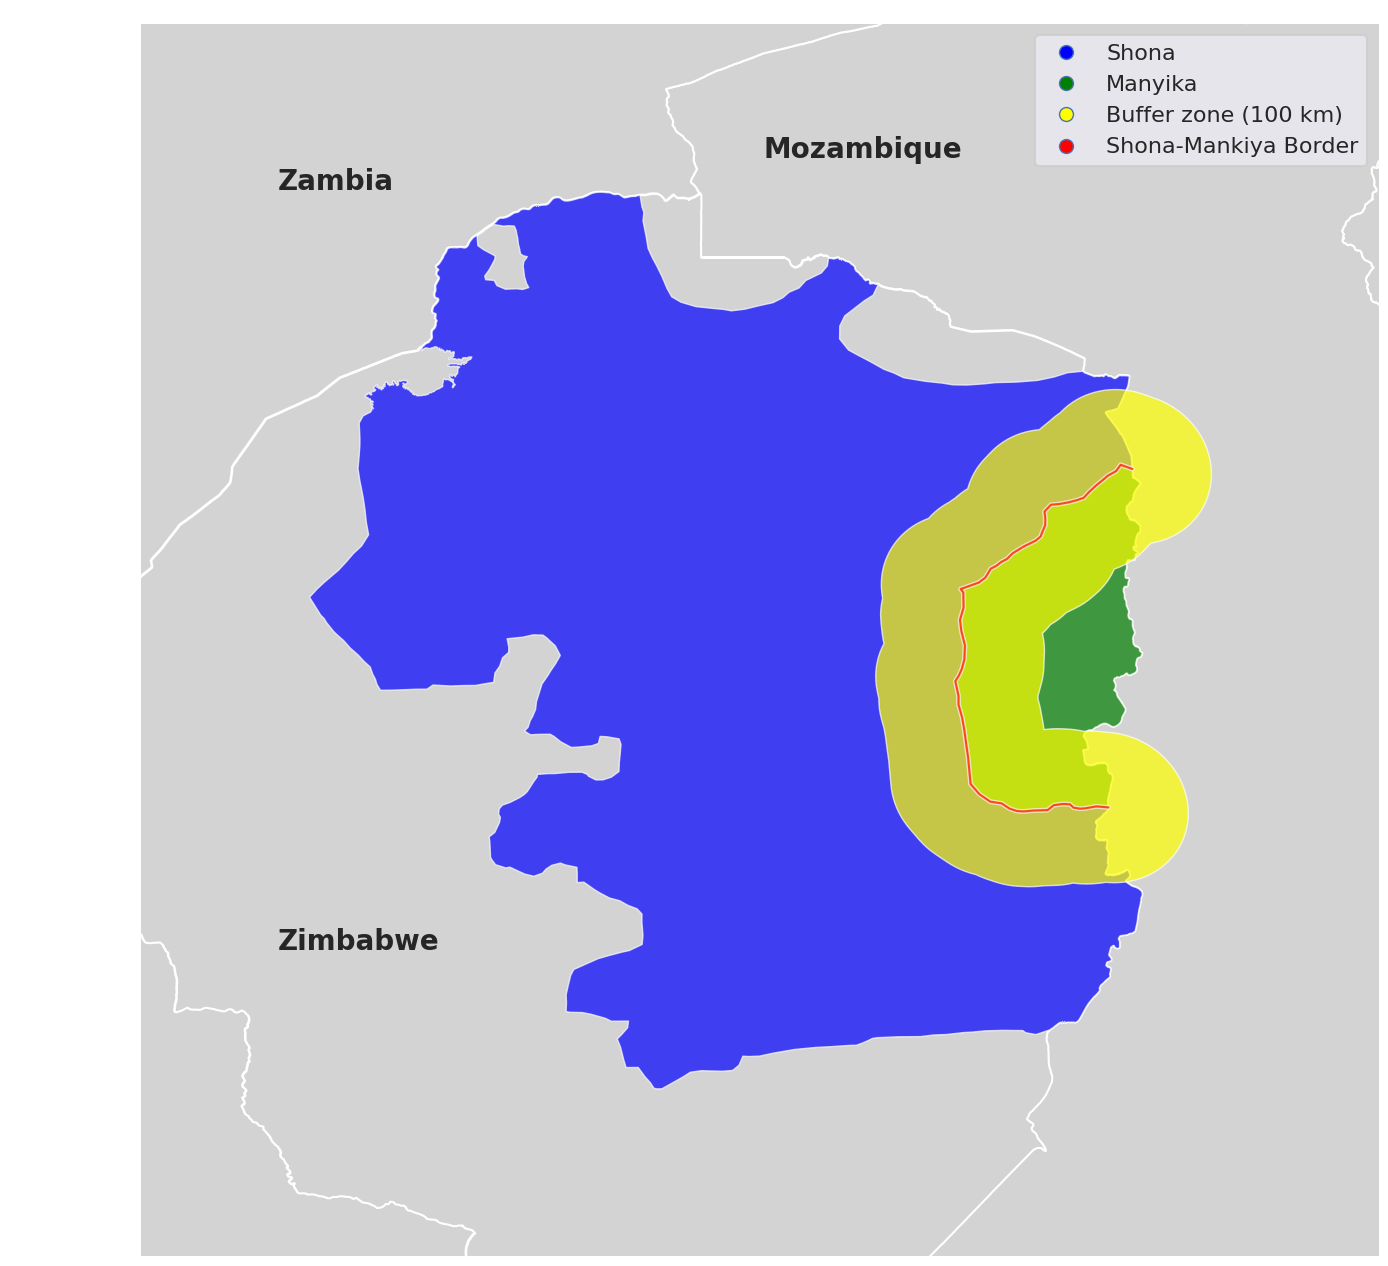

In [ ]:
# Set up bounds of the figure
ethn_or = pd.concat([shona_or, manyika_or])
extent = pd.DataFrame([ethn_or.total_bounds,
                       buffer_or_wgs84.total_bounds,
                       border_or_wgs84.total_bounds,
                      ], columns=['xmin', 'ymin', 'xmax', 'ymax'])
xmin = extent['xmin'].min() - 1
ymin = extent['ymin'].min() - 1
xmax = extent['xmax'].max() + 1
ymax = extent['ymax'].max() + 1
extent = [xmin, ymin, xmax, ymax]

# Set the colors
cmap = ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([ethn_or, buffer_or_wgs84, border_or_wgs84_buf]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

# Plot
ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap, 
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

# Figure 2

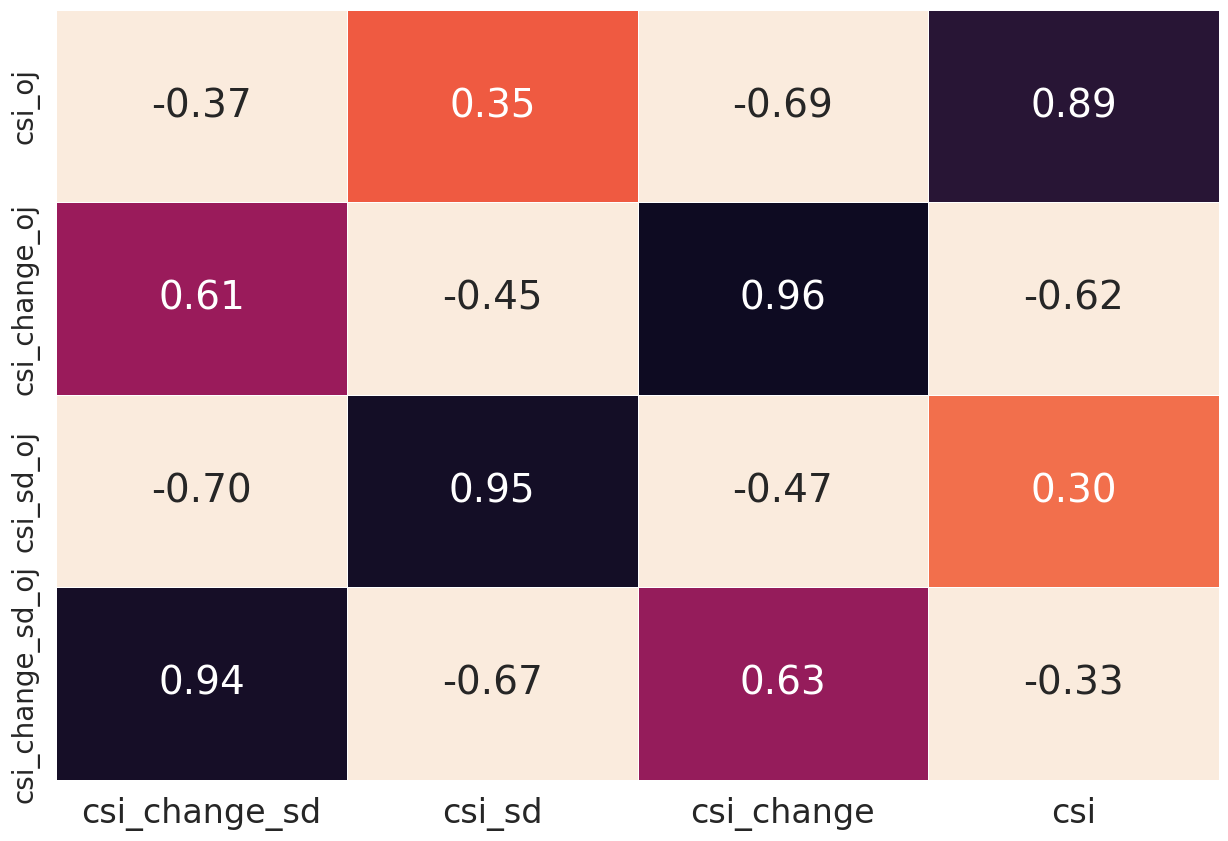

In [ ]:
# Create heatmaps to see the correlation between our data (alternative and reconstructed buffers) with Dicken's variables
var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']
myheatmap(dfor16, var1, var2,'heatmap_v16', show = True)

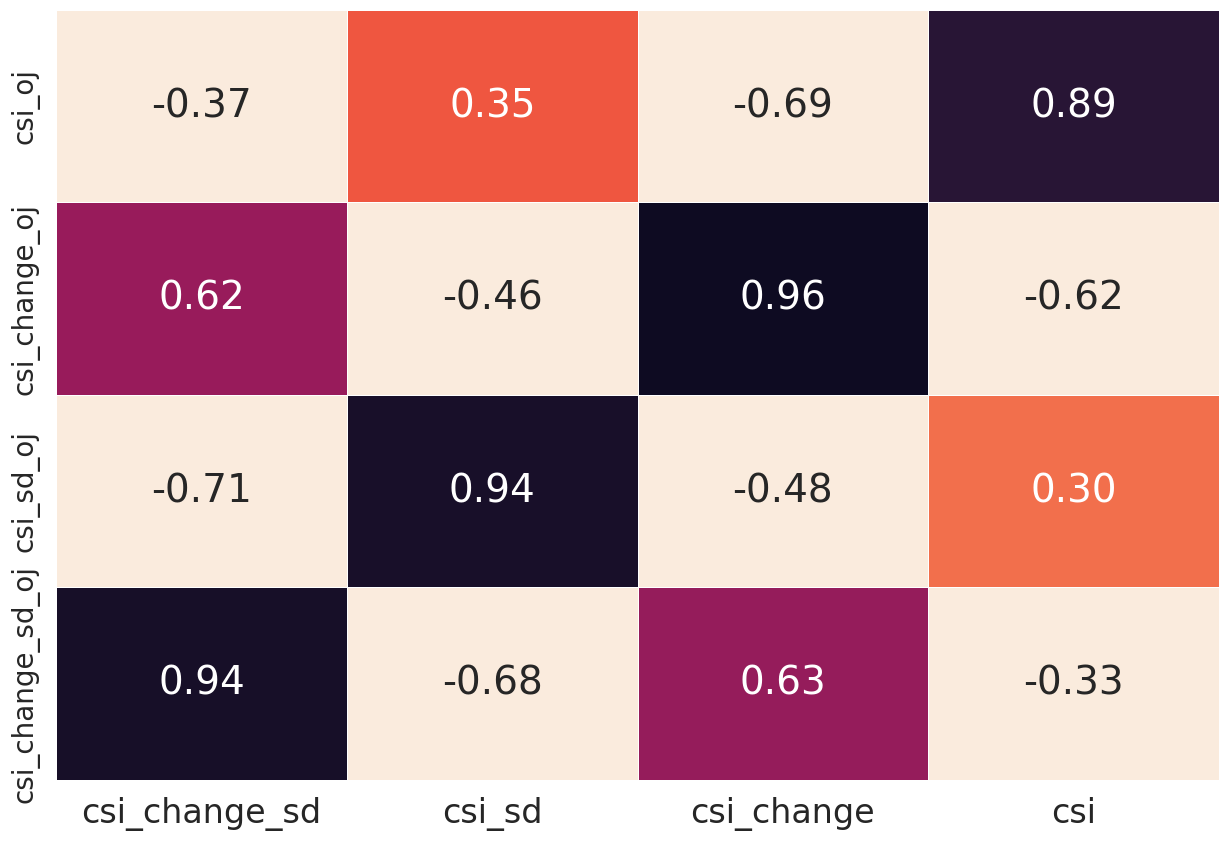

In [ ]:
var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']
myheatmap(dfor17,var1,var2,'heatmap_v17', show = True)

# Table 1

Note that Python doesn't have a package that implements the `reghdfe` procedures.

For this replication we found that using a dummies for the two Language Families provides the closest results.

In [ ]:
# Define the variables of interest
var_of_interest = ['lingDist','csi_change_sd', 'csi_sd']

# Set up some controls
prod = ['csi_change', 'csi']
geog = ['malaria', 'elev', 'elev_sd', 'prec', 'prec_sd', 'temp', 'temp_sd']
spatial = ['ldist_lang', 'ldist_coast', 'ldist_border', 'ldist_lake', 'ldist_rivmaj', 
           'ldist_rivmin', 'ln_langPop', 'ln_langArea', 'langLat_diff', 'langLon_diff']

# Include the main covariates in the right side (variations and levels)
x_vars = ['csi_change_sd', 'csi_sd'] + prod

In [ ]:
# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

## Output to HTML
html_table_1("table1")

In [ ]:
HTML(filename= pathgraphs + "table1.html")

# Figure 3

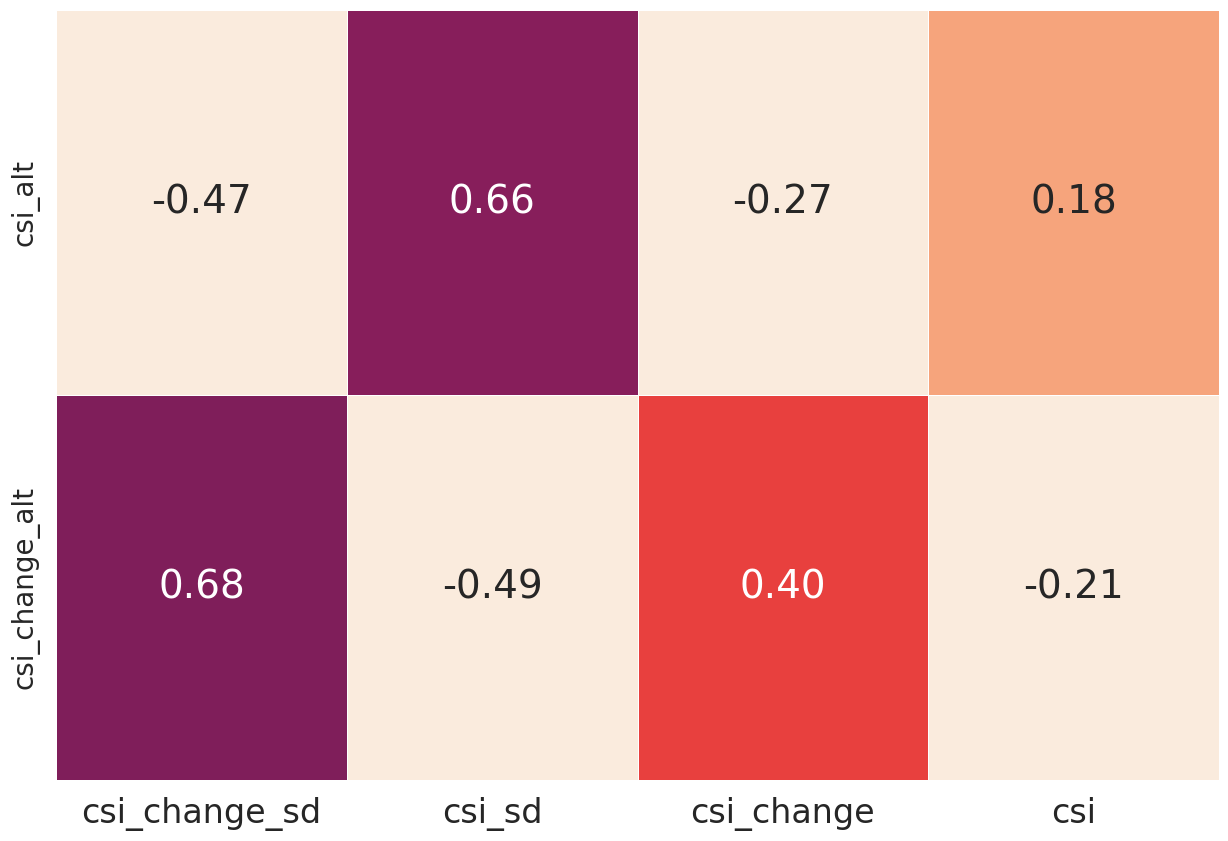

In [ ]:
var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_alt','csi_change_alt']
myheatmap(dfor16, var1, var2,'heatmap_v16_alt', show = True)

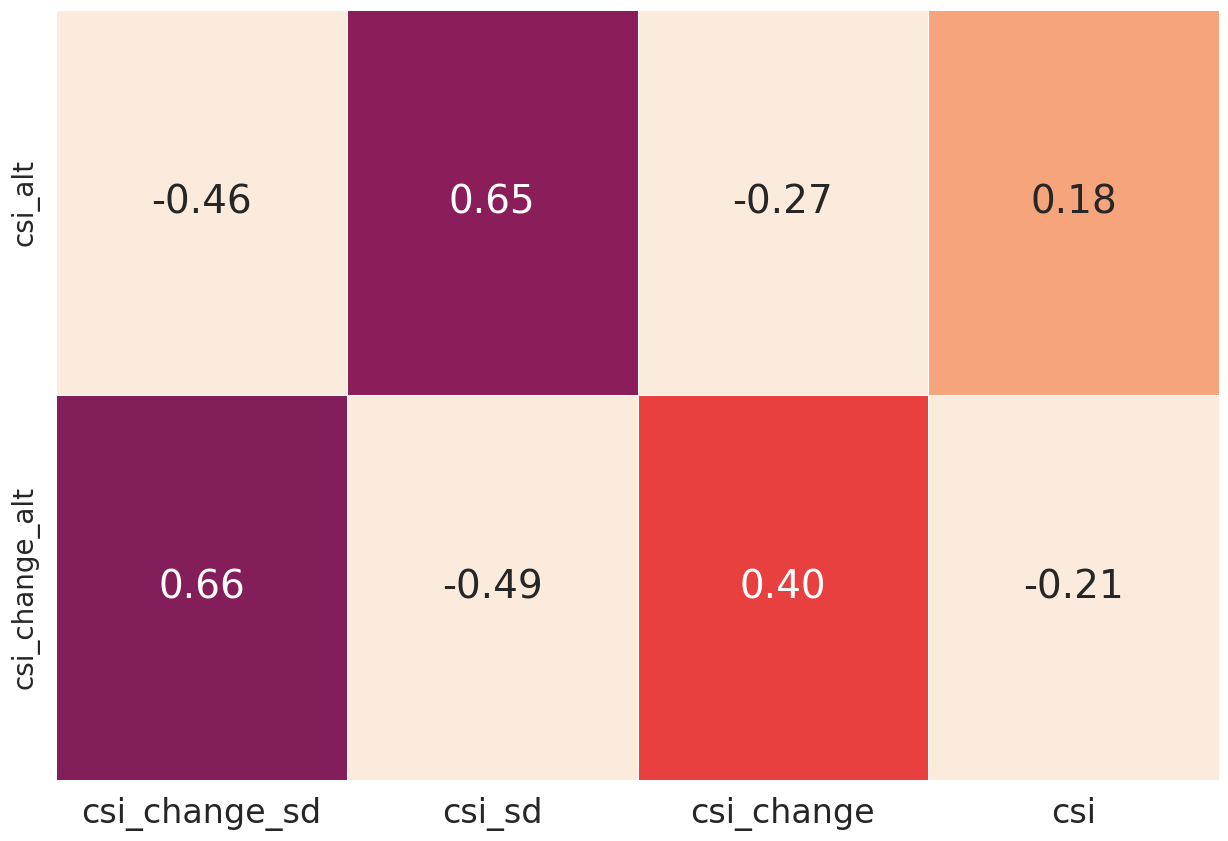

In [ ]:
var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_alt','csi_change_alt']
myheatmap(dfor17,var1,var2,'heatmap_v17_alt', show = True)

# Table 2

In [ ]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Columna 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Columna 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Columna 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Columna 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Columna 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

# Columna 8 : our data alternative buffer, our sample v16, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est8_b = est1.params[x_vars2]
est8_se = est1.bse[x_vars2]
est8_p = est1.pvalues[x_vars2]
ad_R8 = est1.rsquared_adj
N8 = est1.nobs

# Columna 9 : our data alternative buffer, our sample v17, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est9_b = est1.params[x_vars2]
est9_se = est1.bse[x_vars2]
est9_p = est1.pvalues[x_vars2]
ad_R9 = est1.rsquared_adj
N9 = est1.nobs

## Output to HTML
html_table_2("table2")

In [ ]:
HTML(filename=pathgraphs+"table2.html")

# Table A1

In [ ]:
# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

## Output to HTML
html_table_1("tableA1")

In [ ]:
HTML(filename= pathgraphs + "tableA1.html")

## Table A2

In [ ]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Columna 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Columna 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Columna 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Columna 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Columna 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

# Columna 8 : our data alternative buffer, our sample v16, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est8_b = est1.params[x_vars2]
est8_se = est1.bse[x_vars2]
est8_p = est1.pvalues[x_vars2]
ad_R8 = est1.rsquared_adj
N8 = est1.nobs

# Columna 9 : our data alternative buffer, our sample v17, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est9_b = est1.params[x_vars2]
est9_se = est1.bse[x_vars2]
est9_p = est1.pvalues[x_vars2]
ad_R9 = est1.rsquared_adj
N9 = est1.nobs

## Output to HTML
html_table_2("tableA2")

In [ ]:
HTML(filename=pathgraphs+"tableA2.html")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2158a300-6955-4725-92f2-79476c32a378' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>